In [1]:
!pip install -q tensorflow-ranking
!pip install -q --upgrade tensorflow-datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.1 which is incompatible.


In [2]:
from typing import Dict, Tuple

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_ranking as tfr

In [3]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

In [4]:
def preprocess_ratings(data):
    return data.map(lambda x: {
        "user_id": x["user_id"],
        "movie_id": x["movie_id"],
        "timestamp": x["timestamp"],
        "user_rating": x["user_rating"],
        "movie_title": x["movie_title"],
    })

ratings = preprocess_ratings(ratings)

# Display some examples
for row in ratings.take(5).as_numpy_iterator():
    print(row)

{'user_id': b'138', 'movie_id': b'357', 'timestamp': 879024327, 'user_rating': 4.0, 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)"}
{'user_id': b'92', 'movie_id': b'709', 'timestamp': 875654590, 'user_rating': 2.0, 'movie_title': b'Strictly Ballroom (1992)'}
{'user_id': b'301', 'movie_id': b'412', 'timestamp': 882075110, 'user_rating': 4.0, 'movie_title': b'Very Brady Sequel, A (1996)'}
{'user_id': b'60', 'movie_id': b'56', 'timestamp': 883326919, 'user_rating': 4.0, 'movie_title': b'Pulp Fiction (1994)'}
{'user_id': b'197', 'movie_id': b'895', 'timestamp': 891409199, 'user_rating': 3.0, 'movie_title': b'Scream 2 (1997)'}


In [9]:
# Build vocabularies to convert all user ids and all movie titles into integer indices for embedding layers:

user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]).batch(2500))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(ratings.map(lambda x: x["movie_title"]).batch(2500))

In [33]:
# Group by user_id
user_movie_dataset_train = ratings.group_by_window(
    key_func= lambda x: user_ids_vocabulary(x["user_id"]),
    reduce_func=lambda key, dataset: dataset.batch(100),
    window_size=100,
)

# for x in user_movie_dataset_train.take(1):
#   for key, value in x.items():
#     print(f"Shape of {key}: {value.shape}")
#     print(f"Example values of {key}: {value[:5].numpy()}")

In [34]:
def extract_features_and_labels(example: Dict[str, tf.Tensor]) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
    # Extract the label (user_rating) and remove it from the dictionary
    labels = example["user_rating"]  # Save the label (user_rating)
    features = {key: value for key, value in example.items() if key != "user_rating"}  # Keep other features
    return features, labels

user_movie_dataset_train = user_movie_dataset_train.map(extract_features_and_labels) # Now features and labels are splitted in tuples

# Convert the dataset into batches
user_movie_dataset_train = user_movie_dataset_train.apply(
    tf.data.experimental.dense_to_ragged_batch(batch_size=32)
)

In [36]:
for x, label in user_movie_dataset_train.take(1):
  for key, value in x.items():
    print(f"Shape of {key}: {value.shape}")
    print(f"Example values of {key}: {value[10:12, 10:12].numpy()}")
    print()
  print(f"Shape of label: {label.shape}")
  print(f"Example values of label: {label[10:12, 10:12].numpy()}")

Shape of user_id: (32, None)
Example values of user_id: [[b'279' b'279']
 [b'276' b'276']]

Shape of movie_id: (32, None)
Example values of movie_id: [[b'660' b'864']
 [b'21' b'257']]

Shape of timestamp: (32, None)
Example values of timestamp: [[875313473 875296829]
 [874787195 874786657]]

Shape of movie_title: (32, None)
Example values of movie_title: [[b'Fried Green Tomatoes (1991)' b'My Fellow Americans (1996)']
 [b'Muppet Treasure Island (1996)' b'Men in Black (1997)']]

Shape of label: (32, None)
Example values of label: [[4. 5.]
 [3. 4.]]


In [80]:
class TwoTowerMoviesModel(tf.keras.Model):
  def __init__(self, user_ids, movie_titles):
    super().__init__()

    self.user_ids = user_ids
    self.movie_titles = movie_titles

    self.user_embedding_layer = tf.keras.layers.Embedding(
        input_dim=user_ids.vocabulary_size(),
        output_dim=64,
    )
    self.movie_embedding_layer = tf.keras.layers.Embedding(
        input_dim=movie_titles.vocabulary_size(),
        output_dim=64,
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embeddings = self.user_embedding_layer(self.user_ids(features["user_id"]))
    movie_embeddings = self.movie_embedding_layer(
        self.movie_titles(features["movie_title"]))

    return tf.reduce_sum(user_embeddings * movie_embeddings, axis=2)

# Create the ranking model, trained with a ranking loss and evaluated with
# ranking metrics.
model = TwoTowerMoviesModel(user_ids_vocabulary, movie_titles_vocabulary)
optimizer = tf.keras.optimizers.Adagrad(0.5)
loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True
)
eval_metrics = [
    tfr.keras.metrics.get(tfr.keras.metrics.RankingMetricKey.NDCG, ragged=True),
    tfr.keras.metrics.get(tfr.keras.metrics.RankingMetricKey.MRR, ragged=True),
    tfr.keras.metrics.get(tfr.keras.metrics.RankingMetricKey.MAP, ragged=True),
    tfr.keras.metrics.get(tfr.keras.metrics.RankingMetricKey.HITS, topn = 100, ragged=True),
]
model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

In [84]:
import matplotlib.pyplot as plt

# Fit the model and store the history
history = model.fit(user_movie_dataset_train, epochs=5)

Epoch 1/5
48/48 [==============================] - 6s 102ms/step - loss: 992.9807 - ndcg_metric_12: 0.9577 - mrr_metric_12: 1.0000 - mean_average_precision_metric_12: 1.0000 - hits_metric_4: 1.0000
Epoch 2/5
48/48 [==============================] - 6s 91ms/step - loss: 991.5983 - ndcg_metric_12: 0.9697 - mrr_metric_12: 1.0000 - mean_average_precision_metric_12: 1.0000 - hits_metric_4: 1.0000
Epoch 3/5
48/48 [==============================] - 6s 93ms/step - loss: 990.6965 - ndcg_metric_12: 0.9780 - mrr_metric_12: 1.0000 - mean_average_precision_metric_12: 1.0000 - hits_metric_4: 1.0000
Epoch 4/5
48/48 [==============================] - 6s 91ms/step - loss: 990.1336 - ndcg_metric_12: 0.9827 - mrr_metric_12: 1.0000 - mean_average_precision_metric_12: 1.0000 - hits_metric_4: 1.0000
Epoch 5/5
48/48 [==============================] - 6s 111ms/step - loss: 989.7628 - ndcg_metric_12: 0.9863 - mrr_metric_12: 1.0000 - mean_average_precision_metric_12: 1.0000 - hits_metric_4: 1.0000


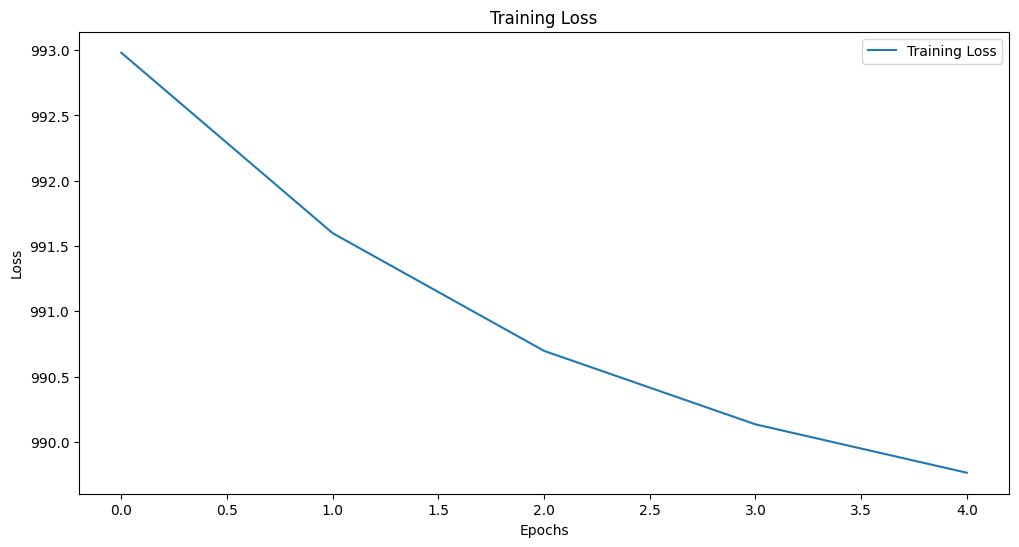

In [85]:
history_dict = history.history

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [88]:
def display_user_rated_movies_and_recommendations(user_id, ratings_dataset, model, movies):
    user_ratings = ratings.filter(lambda x: x['user_id'] == user_id)
    movie_titles_rated = user_ratings.map(lambda x: x['movie_title'])
    scores_rated = user_ratings.map(lambda x: x['user_rating'])

    print(f"Movies rated 5/5 by user {user_id}:")
    for title, score in zip(movie_titles_rated, scores_rated):
      if score > 4:
        print(f"Movie: {title.numpy().decode('utf-8')}, Rating: {score.numpy()}")

    movie_titles = movies.batch(2000).take(1).get_single_element()  # Get a batch of movie titles
    inputs = {
        "user_id": tf.expand_dims(tf.repeat(user_id, repeats=movie_titles.shape[0]), axis=0),
        "movie_title": tf.expand_dims(movie_titles, axis=0)
    }

    scores = model(inputs)
    titles = tfr.utils.sort_by_scores(scores, [tf.expand_dims(movie_titles, axis=0)])[0]

    print(f"\nTop 5 recommendations for user {user_id}:")
    for title in titles[0, :5]:
        print(f"Movie: {title.numpy().decode('utf-8')}")

display_user_rated_movies_and_recommendations(user_id="433", ratings_dataset=ratings, model=model, movies=movies)


Movies rated 5/5 by user 433:
Movie: Raiders of the Lost Ark (1981), Rating: 5.0
Movie: Usual Suspects, The (1995), Rating: 5.0
Movie: Double vie de Véronique, La (Double Life of Veronique, The) (1991), Rating: 5.0
Movie: Three Colors: Red (1994), Rating: 5.0
Movie: Full Monty, The (1997), Rating: 5.0
Movie: Three Colors: Blue (1993), Rating: 5.0
Movie: Leaving Las Vegas (1995), Rating: 5.0
Movie: L.A. Confidential (1997), Rating: 5.0
Movie: Manchurian Candidate, The (1962), Rating: 5.0
Movie: Sting, The (1973), Rating: 5.0
Movie: Star Wars (1977), Rating: 5.0
Movie: City of Lost Children, The (1995), Rating: 5.0
Movie: Big Night (1996), Rating: 5.0
Movie: English Patient, The (1996), Rating: 5.0

Top 5 recommendations for user 433:
Movie: My Life as a Dog (Mitt liv som hund) (1985)
Movie: Lone Star (1996)
Movie: Pulp Fiction (1994)
Movie: Close Shave, A (1995)
Movie: Wallace & Gromit: The Best of Aardman Animation (1996)
